<a href="https://colab.research.google.com/github/chimi-pt/Automatic-Text-Summarization-using-NLP-and-Tensor-Flow/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading and Segregating the Dataset**

In [ ]:
# get the CNN stories dataset
!wget https://github.com/Manning-LP-What-s-The-News/Starter-Repository/releases/download/v0.1.0/cnn_stories.tgz

# untar the dataset
!tar -xvf cnn_stories.tgz

In [2]:
# dependencies
from tqdm.notebook import tqdm
from os import listdir
import string

In [3]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    
    return text

# split a document into news story and highlights
def split_story(doc):
    
    #find first highlight
    index = doc.find('@highlight')
    
    # split into story and highlights
    story, highlights = doc[:index], doc[index:].split('@highlight')
    
    # strip extra white space around each highlight
    highlights = [h.strip() for h in highlights if len(h) > 0]
    
    return story, highlights

# load all stories in a directory
def load_stories(directory):
    stories = list()
    
    for name in tqdm(listdir(directory)):
        filename = directory + '/' + name
        
        # load document
        doc = load_doc(filename)
        
        # split into story and highlights
        story, highlights = split_story(doc)
        
        # store
        stories.append({'story':story, 'highlights':highlights})
    
    return stories

In [4]:
# segregate into news and summaries
directory = 'cnn/stories/'
stories = load_stories(directory)
print('Loaded Stories %d' % len(stories))

  0%|          | 0/92579 [00:00<?, ?it/s]

Loaded Stories 92579


In [5]:
# serialize the master list
from pickle import dump
dump(stories, open('stories.pkl', 'wb'))

# **Preprocessing the stories and the summaries**

## Converting all words to lowercase.
Removing all punctuation
No numerical tokens are present.

In [6]:
#Additional dependecies
from pickle import load
import pandas as pd
import numpy as np

In [7]:
# load stories and summaries' list
stories = load(open('stories.pkl', 'rb'))
print('Loaded Stories %d' % len(stories))

Loaded Stories 92579


In [8]:
#Cleaning a list of lines
def clean_lines(lines):
    cleaned=list()
    #Remove puntctuations by preparing a translation table
    table=str.maketrans('','',string.punctuation)
    for line in lines:
        # stripping the source cnn office
        index=line.find('(CNN) --')
        if index > -1:
            line=line[index+len('(CNN)'):]
        # tokenize on white space
        line=line.split()
        #convert to lowercase
        line=[word.lower() for word in line]
        #remove punctuation from each token
        line=[w.translate(table) for w in line]
        #remove tokens with numbers in item
        line=[word for word in line if word.isalpha()]
        #store as string
        cleaned.append(''.join(line))
    #remove empty strings
    cleaned=[c for c in cleaned if len(c) > 0]

    return cleaned

## Cleaning the stories and summaries

In [9]:
for example in tqdm(stories):
  example['story']=clean_lines(example['story'].split('\n'))
  example['highlights']= clean_lines(example['highlights'])
  

  0%|          | 0/92579 [00:00<?, ?it/s]

# Extracting Summaries from the Stories with ROUGE Score

## Installing the rouge module  for calculating the rouge scores

In [10]:
!pip install -q Rouge

In [11]:
#Import the rouge module  and instantiate it
from rouge  import Rouge
rouge=Rouge()

#utility for calculating Rouge score between pairs of sentences
def get_rouge_f1(references,sentence):
  score_ls=[]
  for ans in references:
    scores=rouge.get_scores(ans,sentence)
    score_ls.append(scores[0]['rouge-1']['f'])

    return max(score_ls)


In [12]:
def get_list_ans_each_story(story_inp,references_inp):

  scr=[]
  hyp=[]

  #iterate through each sentence of a given story
  for i in range(0,len(story_inp)):
    #Calculate the rouge score between  the current sentence  and the provided abstractive summaries
    hypothesis=story_inp[i]
    scores=get_rouge_f1(references_inp,hypothesis)

    #track sentences iterated and store their scores
    hyp.append(hypothesis)
    scr.append(scores)

  #convert to numpy array
  hyp1=np.array(hyp)

  #sort the scores to get the indices
  scr1=np.array(scr)
  scr2 = np.sort(scr)[::-1]
  ind  = np.argsort(scr)[::-1]
    
  # take top 5 
  ind1 = ind[0:5]
  list_ref = list(hyp1[ind1])
    
  return list_ref, scr2[0:5]


In [13]:
dict_id_summary={}
dict_id_score={}

#iterate through each story
for s_id in tqdm(range(0,len(stories))):

  #story inputs(each sentence of a story)
  story_inp=stories[s_id]['story']

  #reference inputs (abstractive summaries)
  references_inp=stories[s_id]['highlights']

  #get the list of references and scores
  list_ref,list_score=get_list_ans_each_story(story_inp,references_inp)

  #store the results in the dictionaries
  dict_id_summary[s_id]=list_ref
  dict_id_score[s_id]=list_score

  0%|          | 0/92579 [00:00<?, ?it/s]

## Storing the dictionaries created above as `.pkl` files

In [14]:
story_id=[]
label_sent=[]
sent_id=[]
list_sent=[]

#iterating through each story
for i in tqdm(range(0, len(stories))):

  #list references for the story
  list_ref=dict_id_summary[i]

  # iterating through each sentence of the current story
  for j, story in enumerate(stories[i]['story']) :
        
        # check if the story is in the list reference
        ind =  int(story in list_ref)
        
        # append the indicator as the labels
        label_sent.append(ind)
        
        # 1. append the sentences per story
        list_sent.append(story)
        
        # 2. append the sent_ids
        sent_id.append(j)
        
        # 3. append the story_id
        story_id.append(i)

  0%|          | 0/92579 [00:00<?, ?it/s]

In [15]:
#create the dataframe
df_story_summary=pd.DataFrame()

df_story_summary['story_id']=story_id
df_story_summary['sent_id']=sent_id
df_story_summary['sentence']=list_sent
df_story_summary['label_sent']=label_sent



## Preview

In [16]:
df_story_summary.head()

,story_id,sent_id,sentence,label_sent
0,0,0,spainsjorgelorenzoextendedhisleadintheworldcha...,0
1,0,1,theyamaharideroverhauledreigningworldchampions...,0
2,0,2,onlyabadmistakewithfourlapstogomighthavecostlo...,0
3,0,3,itextendedlorenzosleadoveraustraliasstonerwhoh...,0
4,0,4,itwaswonderfulfightingwithcaseywerehavingafant...,0


In [17]:
# serialize
df_story_summary.to_pickle('dataframe_extractive.pkl')

# Dataset Subsampling and Splitting

Creating a small sample from the original dataset and further split the sample into training, validation, and test sets.Important because it finalizes the input training dataset that will go into the model.

In [18]:
#dependecies

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random 

from tqdm import tqdm
from itertools import chain
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [19]:
#tensor flow version

print(tf.__version__)

2.9.2


ensure that the seeds are set properly in order to provide reproducible results.

In [20]:
#fixing the seed for better reproductibility
SEED=42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


In [21]:
# make tqdm work with pandas
tqdm.pandas()

Dataset splititng and visualization

In [22]:
# we serialized the dataset for reuse, now's the time to do it
# load the dataset and preview
data = pd.read_pickle('dataframe_extractive.pkl')
data.head()

,story_id,sent_id,sentence,label_sent
0,0,0,spainsjorgelorenzoextendedhisleadintheworldcha...,0
1,0,1,theyamaharideroverhauledreigningworldchampions...,0
2,0,2,onlyabadmistakewithfourlapstogomighthavecostlo...,0
3,0,3,itextendedlorenzosleadoveraustraliasstonerwhoh...,0
4,0,4,itwaswonderfulfightingwithcaseywerehavingafant...,0


In [23]:
#story length distribution
d1_sent_count=data.groupby('story_id').size().reset_index(name='count_sentences')
d1_sent_count.head()

,story_id,count_sentences
0,0,10
1,1,17
2,2,62
3,3,6
4,4,29


#calculating the median length of the stories


In [24]:
d1_sent_count['count_sentences'].median()

19.0

In [25]:
#filtering the length of the stories that have a length greater than 30
list_stories_subset=list(d1_sent_count[d1_sent_count['count_sentences'] < 30]['story_id'])
len(list_stories_subset)

74223

## Randomly sample 50,000 unique stories from the filtered-out story IDs.

In [26]:
#subsetting the stories so that it can run on the system
SUBSET=50000
list_stories_subset=random.sample(list_stories_subset,SUBSET)
len(np.unique(list_stories_subset))

50000

## Split these randomly sampled story IDs into three sets—training, validation, and testing—in a 3:1:1 ratio.

In [27]:
#segregating  into different split
train_ids=list_stories_subset[:30000]
validation_ids=list_stories_subset[30000:40000]
test_ids=list_stories_subset[40000:]

train=data[data['story_id'].isin(train_ids)]
valid=data[data['story_id'].isin(validation_ids)]
test=data[data['story_id'].isin(test_ids)]

train.shape,valid.shape,test.shape

((504862, 4), (167713, 4), (168540, 4))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


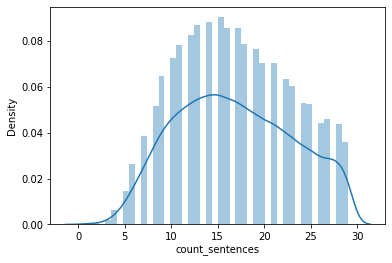

In [28]:
#story length disribution plot in the training dataset
train=train.sort_values(['story_id','sent_id'])
d2_sent_count=train.groupby('story_id').size().reset_index(name='count_sentences')
sns.distplot(d2_sent_count['count_sentences'])
plt.show()

In [29]:
#descriptive  statistics  of story length in the training dataset
d2_sent_count['count_sentences'].describe()

count    30000.000000
mean        16.828733
std          6.220425
min          1.000000
25%         12.000000
50%         16.000000
75%         22.000000
max         29.000000
Name: count_sentences, dtype: float64

In [30]:
#Note the maximum story length from the  training dataset
#use this statistic for preprocessing
max_len_story=d2_sent_count['count_sentences'].max()
max_len_story

29

In [31]:
#total number of unique sentences in the training dataset
sent_ls=set(train['sentence'].tolist())
len(sent_ls) 

484636

In [32]:
#unique labels in the training dataset
#0 - sentence is not a summary candidate
#1 - sentence is a summary candidate
tags=list(set(train['label_sent'].values))
n_tags=len(tags)
n_tags

2

# Dataset Preprocessing

Represent the sentences with integer tokens, pad the sentences to the maximum sentence length, and represent the corresponding labels in 0s and 1s.

This is an important step, as it helps with choosing and setting some of the model configuration parameters, such as the maximum_story_length and maximum_sentence_length.
The choice regarding the maximum_story_length and maximum_sentence_length is determined based on the statistical distribution of those parameters and for the majority of the stories in the dataset.

In [33]:
#encoding the sentence labels and reversing them
#Find the total number of unique labels all the sentences associate with and create a dictionary to map each label to integer numbers.
#The dictionary should also contain a key called “PAD,” and its value should be set to zero.
tag2idx={t:i + 1 for i, t in enumerate(tags)}
tag2idx['PAD']=0 
id2xtag ={i: s for s, i in tag2idx.items()}
print(tag2idx)

{0: 1, 1: 2, 'PAD': 0}


In [34]:
def add_word_lengths(df):
   df['word_length'] = df['sentence'].progress_apply(lambda x: len(x.split()))
   df['word_lis'] = df['sentence'].progress_apply(lambda x: x.split())
   return df

In [35]:
train = add_word_lengths(train)
valid = add_word_lengths(valid)
test = add_word_lengths(test)

train.head()

100%|██████████| 167713/167713 [00:00<00:00, 562417.14it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 167713/167713 [00:00<00:00, 510969.77it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 168540/168540 [00:00<00:00, 174023.11it/s]


,story_id,sent_id,sentence,label_sent,word_length,word_lis
0,0,0,spainsjorgelorenzoextendedhisleadintheworldcha...,0,1,[spainsjorgelorenzoextendedhisleadintheworldch...
1,0,1,theyamaharideroverhauledreigningworldchampions...,0,1,[theyamaharideroverhauledreigningworldchampion...
2,0,2,onlyabadmistakewithfourlapstogomighthavecostlo...,0,1,[onlyabadmistakewithfourlapstogomighthavecostl...
3,0,3,itextendedlorenzosleadoveraustraliasstonerwhoh...,0,1,[itextendedlorenzosleadoveraustraliasstonerwho...
4,0,4,itwaswonderfulfightingwithcaseywerehavingafant...,0,1,[itwaswonderfulfightingwithcaseywerehavingafan...
